<center><h1>1-cd: Convolutional Neural Networks (ConvNets)</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Samy NEHLIL - Allaa BOUTALEB


In [1]:
#!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py

--2023-11-05 22:16:03--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2023-11-05 22:16:03--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.57K  --.-KB/s    in 0s      

2023-11-05 22:16:04 (55.7 MB/s) - ‘utils.py’ saved [2627/2627]



In [2]:
%run 'utils.py'

In [3]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

### Test on MNIST Dataset

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.MNIST(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.MNIST(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            # if optimizer:
            #     loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


class AccLossPlot:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
        self.epoch_range = []

    def update(self, train_loss, test_loss, train_accuracy, test_accuracy, epoch):
        self.train_losses.append(train_loss)
        self.test_losses.append(test_loss)
        self.train_accuracies.append(train_accuracy)
        self.test_accuracies.append(test_accuracy)
        self.epoch_range.append(epoch)

    def plot(self):
        plt.figure(figsize=(10, 10))

        # Plot Train Loss
        plt.subplot(2, 2, 1)
        plt.plot(self.epoch_range, self.train_losses, label="Train Loss", marker='o', c="g")
        plt.xlabel("Epoch")
        plt.ylabel("Train Loss")
        plt.title("Training Loss")
        plt.grid(True)

        # Plot Test Loss
        plt.subplot(2, 2, 2)
        plt.plot(self.epoch_range, self.test_losses, label="Test Loss", marker='o', c="b")
        plt.xlabel("Epoch")
        plt.ylabel("Test Loss")
        plt.title("Testing Loss")
        plt.grid(True)

        # Plot Train Accuracy
        plt.subplot(2, 2, 3)
        plt.plot(self.epoch_range, self.train_accuracies, label="Train Accuracy", marker='o', c="r")
        plt.xlabel("Epoch")
        plt.ylabel("Train Accuracy")
        plt.title("Training Accuracy")
        plt.grid(True)

        # Plot Test Accuracy
        plt.subplot(2, 2, 4)
        plt.plot(self.epoch_range, self.test_accuracies, label="Test Accuracy", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Test Accuracy")
        plt.title("Testing Accuracy")
        plt.grid(True)

        plt.tight_layout()

    def save_plot(self, filename):
        self.plot()
        plt.savefig(filename)
        plt.close()

def main(batch_size=128, lr=0.1, epochs=5, cuda=False):
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # update plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg, i+1)

    # Plot and display the final result
    plot.plot()
    plt.show()


=== EPOCH 1 =====

[TRAIN Batch 000/469]	Time 0.137s (0.137s)	Loss 2.3035 (2.3035)	Prec@1   9.4 (  9.4)	Prec@5  51.6 ( 51.6)
[TRAIN Batch 200/469]	Time 0.015s (0.016s)	Loss 2.2843 (2.2928)	Prec@1  19.5 ( 13.6)	Prec@5  59.4 ( 56.4)
[TRAIN Batch 400/469]	Time 0.025s (0.015s)	Loss 2.2013 (2.2697)	Prec@1  43.0 ( 21.4)	Prec@5  84.4 ( 65.3)

===============> Total time 7s	Avg loss 2.2551	Avg Prec@1 24.48 %	Avg Prec@5 68.40 %

[EVAL Batch 000/079]	Time 0.205s (0.205s)	Loss 2.1289 (2.1289)	Prec@1  50.0 ( 50.0)	Prec@5  88.3 ( 88.3)

===============> Total time 1s	Avg loss 2.1262	Avg Prec@1 48.13 %	Avg Prec@5 88.16 %

=== EPOCH 2 =====

[TRAIN Batch 000/469]	Time 0.148s (0.148s)	Loss 2.1031 (2.1031)	Prec@1  49.2 ( 49.2)	Prec@5  90.6 ( 90.6)
[TRAIN Batch 200/469]	Time 0.017s (0.018s)	Loss 1.6353 (1.9141)	Prec@1  54.7 ( 48.9)	Prec@5  93.8 ( 90.7)
[TRAIN Batch 400/469]	Time 0.022s (0.017s)	Loss 1.1305 (1.6483)	Prec@1  73.4 ( 55.8)	Prec@5  96.9 ( 93.4)

===============> Total time 8s	Avg loss 1.5632

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


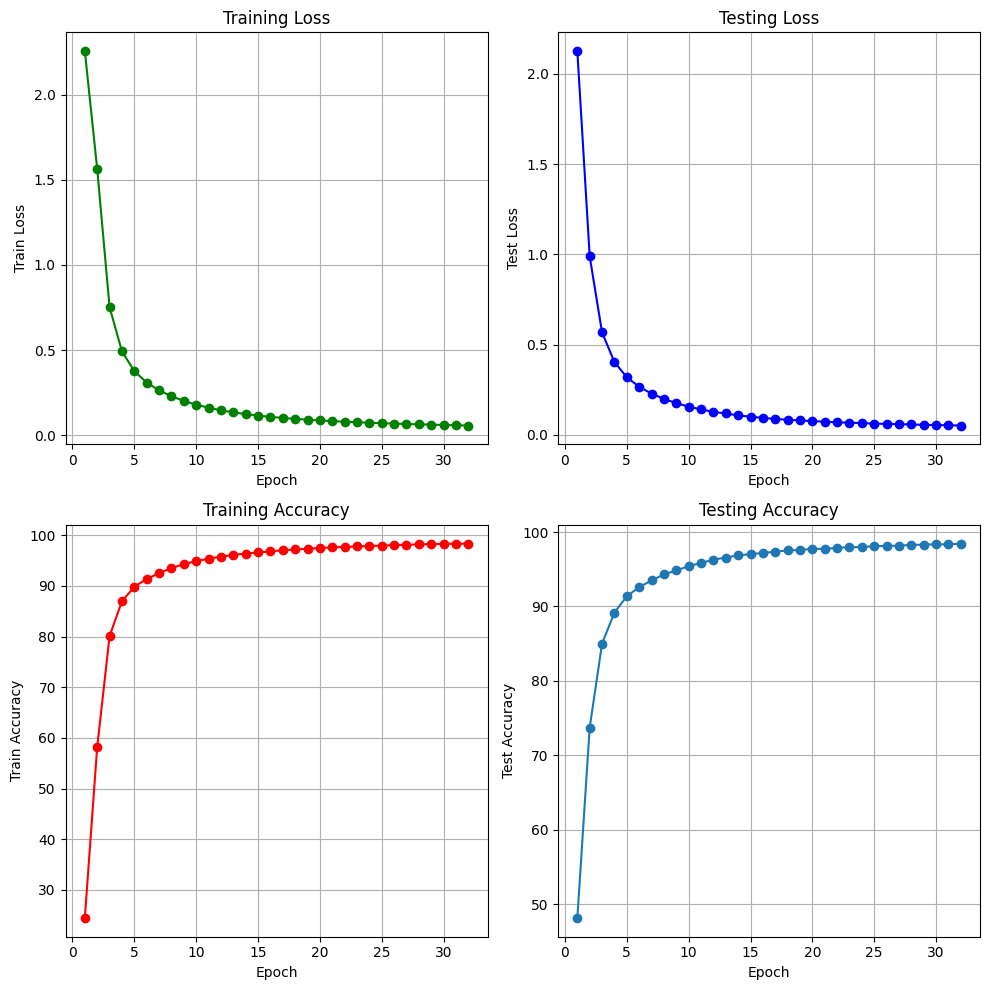

In [ ]:
main(128, 0.01, epochs=32, cuda=True)

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """
    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

def get_dataset(batch_size, cuda=False, transform=None):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    download = False
    if not os.path.isfile(f"{PATH}/cifar-10-python.tar.gz"):
        download = True

    if transform == "normalize":
        transform_train = transform_test = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201]),
            ]
        )
    elif transform == "augmentation":
        transform_train = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.RandomCrop(28),
                transforms.RandomHorizontalFlip(),
            ]
        )
        transform_test = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(28)])
    else:
        transform_train = transform_test = transforms.Compose([transforms.ToTensor()])

        train_dataset = datasets.CIFAR10(
        PATH,
        train=True,
        download=download,
        transform=transform_train,
    )
    val_dataset = datasets.CIFAR10(
        PATH,
        train=False,
        download=download,
        transform=transform_test,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=cuda,
        num_workers=2,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=cuda,
        num_workers=2,
    )

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        # if optimizer:
        #     loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            # if optimizer:
            #     loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


class AccLossPlot:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
        self.epoch_range = []

    def update(self, train_loss, test_loss, train_accuracy, test_accuracy, epoch):
        self.train_losses.append(train_loss)
        self.test_losses.append(test_loss)
        self.train_accuracies.append(train_accuracy)
        self.test_accuracies.append(test_accuracy)
        self.epoch_range.append(epoch)

    def plot(self):
        plt.figure(figsize=(10, 10))

        # Plot Train Loss
        plt.subplot(2, 2, 1)
        plt.plot(self.epoch_range, self.train_losses, label="Train Loss", marker='o', c="g")
        plt.xlabel("Epoch")
        plt.ylabel("Train Loss")
        plt.title("Training Loss")
        plt.grid(True)

        # Plot Test Loss
        plt.subplot(2, 2, 2)
        plt.plot(self.epoch_range, self.test_losses, label="Test Loss", marker='o', c="b")
        plt.xlabel("Epoch")
        plt.ylabel("Test Loss")
        plt.title("Testing Loss")
        plt.grid(True)

        # Plot Train Accuracy
        plt.subplot(2, 2, 3)
        plt.plot(self.epoch_range, self.train_accuracies, label="Train Accuracy", marker='o', c="r")
        plt.xlabel("Epoch")
        plt.ylabel("Train Accuracy")
        plt.title("Training Accuracy")
        plt.grid(True)

        # Plot Test Accuracy
        plt.subplot(2, 2, 4)
        plt.plot(self.epoch_range, self.test_accuracies, label="Test Accuracy", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Test Accuracy")
        plt.title("Testing Accuracy")
        plt.grid(True)

        plt.tight_layout()

    def save_plot(self, filename):
        self.plot()
        plt.savefig(filename)
        plt.close()

def main(batch_size=128, lr=0.1, epochs=5, cuda=False):
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # update plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg, i+1)

    # Plot and display the final result
    plot.plot()
    plt.show()

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.128s (0.128s)	Loss 2.3034 (2.3034)	Prec@1   6.2 (  6.2)	Prec@5  50.0 ( 50.0)
[TRAIN Batch 200/391]	Time 0.014s (0.025s)	Loss 2.2979 (2.3002)	Prec@1  11.7 ( 11.4)	Prec@5  47.7 ( 52.5)

===============> Total time 9s	Avg loss 2.2966	Avg Prec@1 10.61 %	Avg Prec@5 52.17 %

[EVAL Batch 000/079]	Time 0.111s (0.111s)	Loss 2.2832 (2.2832)	Prec@1  13.3 ( 13.3)	Prec@5  50.8 ( 50.8)

===============> Total time 1s	Avg loss 2.2847	Avg Prec@1 12.76 %	Avg Prec@5 54.63 %

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.098s (0.098s)	Loss 2.2895 (2.2895)	Prec@1  11.7 ( 11.7)	Prec@5  48.4 ( 48.4)
[TRAIN Batch 200/391]	Time 0.015s (0.027s)	Loss 2.2408 (2.2690)	Prec@1  16.4 ( 12.7)	Prec@5  66.4 ( 58.1)

===============> Total time 9s	Avg loss 2.2202	Avg Prec@1 16.52 %	Avg Prec@5 64.20 %

[EVAL Batch 000/079]	Time 0.099s (0.099s)	Loss 2.0892 (2.0892)	Prec@1  23.4 ( 23.4)	Prec@5  77.3

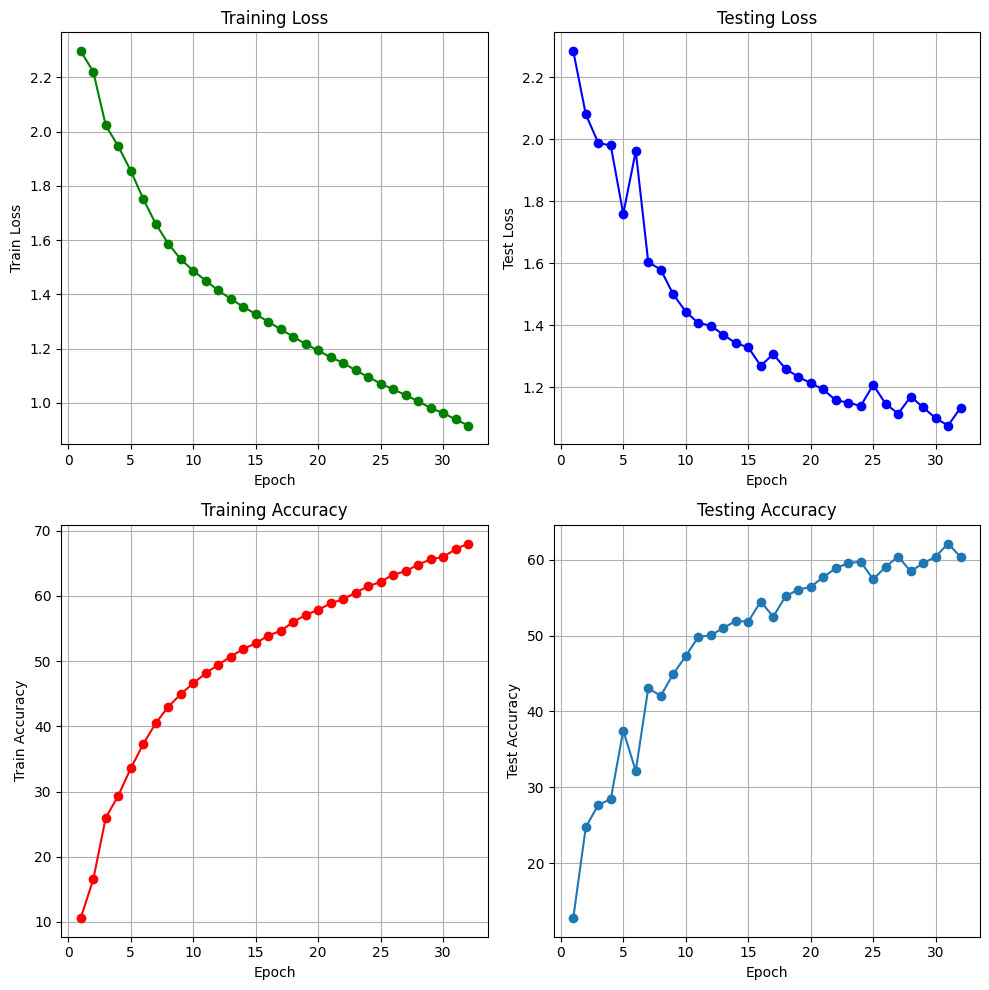

In [ ]:
main(128, 0.01,epochs=32, cuda=True)

### 2 Network architecture

In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time

# Assuming other necessary imports are done and rest of the code remains unchanged
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """
    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

def get_dataset(batch_size, cuda=False, transform=None):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    download = False
    if not os.path.isfile(f"{PATH}/cifar-10-python.tar.gz"):
        download = True

    if transform == "normalize":
        transform_train = transform_test = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201]),
            ]
        )
    elif transform == "augmentation":
        transform_train = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201]),
                transforms.RandomCrop(28),
                transforms.RandomHorizontalFlip(),
            ]
        )
        transform_test = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201]),
                                             transforms.CenterCrop(28)])
    else:
        transform_train = transform_test = transforms.Compose([transforms.ToTensor()])

    train_dataset = datasets.CIFAR10(
    PATH,
    train=True,
    download=download,
    transform=transform_train,
    )
    val_dataset = datasets.CIFAR10(
        PATH,
        train=False,
        download=download,
        transform=transform_test,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=cuda,
        num_workers=2,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=cuda,
        num_workers=2,
    )

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        # if optimizer:
        #     loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            # if optimizer:
            #     loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


class EnhancedAccLossPlot:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
        self.epochs = []

    def update(self, train_loss, test_loss, train_accuracy, test_accuracy, epoch):
        self.train_losses.append(train_loss)
        self.test_losses.append(test_loss)
        self.train_accuracies.append(train_accuracy)
        self.test_accuracies.append(test_accuracy)
        self.epochs.append(epoch)

    def plot_metrics(self, train_metric, test_metric, metric_name, subplot_position):
        plt.subplot(subplot_position)
        plt.plot(self.epochs, train_metric, label=f"Train {metric_name}", marker='o', linestyle='-', color='blue')
        plt.plot(self.epochs, test_metric, label=f"Test {metric_name}", marker='o', linestyle='--', color='orange')
        plt.xlabel("Epoch")
        plt.ylabel(metric_name)
        plt.title(f"Training vs Testing {metric_name}")
        plt.legend()
        plt.grid(True)

    def plot(self, filename=None):
        plt.figure(figsize=(14, 6))

        # Plot Loss
        self.plot_metrics(self.train_losses, self.test_losses, "Loss", 121)

        # Plot Accuracy
        self.plot_metrics(self.train_accuracies, self.test_accuracies, "Accuracy", 122)

        plt.tight_layout()

        if filename:
            plt.savefig(filename)
            plt.show()
        else:
            plt.show()
        plt.close()

# Assuming rest of the ConvNet, epoch function and main function definitions remain unchanged
def main(batch_size=128, lr=0.01, epochs=100, cuda=True, transform=None, scheduler=False, plot_name="training_performance.png"):
    # Previous setup remains unchanged ...

    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if scheduler:
      lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda, transform)

    # Initialize enhanced plotter
    enhanced_plot = EnhancedAccLossPlot()

    for i in range(epochs):
        # Previous training and evaluation code remains unchanged ...
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)

        if scheduler:
          lr_sched.step()

        # Update enhanced plotter with the latest epoch's metrics
        enhanced_plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg, i + 1)

    # Plot and save/show the final result
    enhanced_plot.plot(plot_name)

=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 2.444s (2.444s)	Loss 2.3021 (2.3021)	Prec@1  12.5 ( 12.5)	Prec@5  50.0 ( 50.0)
[TRAIN Batch 200/391]	Time 0.033s (0.031s)	Loss 2.3006 (2.3011)	Prec@1   8.6 ( 11.3)	Prec@5  51.6 ( 50.6)

===============> Total time 9s	Avg loss 2.2984	Avg Prec@1 11.90 %	Avg Prec@5 50.67 %

[EVAL Batch 000/079]	Time 0.096s (0.096s)	Loss 2.2884 (2.2884)	Prec@1  10.2 ( 10.2)	Prec@5  49.2 ( 49.2)

===============> Total time 1s	Avg loss 2.2905	Avg Prec@1 10.71 %	Avg Prec@5 51.65 %

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.141s (0.141s)	Loss 2.2839 (2.2839)	Prec@1  11.7 ( 11.7)	Prec@5  57.0 ( 57.0)
[TRAIN Batch 200/391]	Time 0.013s (0.024s)	Loss 2.2511 (2.2784)	Prec@1  10.2 ( 11.1)	Prec@5  62.5 ( 54.2)

===============> Total time 8s	Avg loss 2.2416	Avg Prec@1 14.53 %	Avg Prec@5 60.77 %

[EVAL Batch 000/079]	Time 0.106s (0.106s)	Loss 2.0991 (2.0991)	Prec@1  27.3 ( 27.3)	Prec@5  78.9 ( 78.9)

===============> Total time 1s	Avg loss 2.1083	Avg Prec@1 23.05 %	

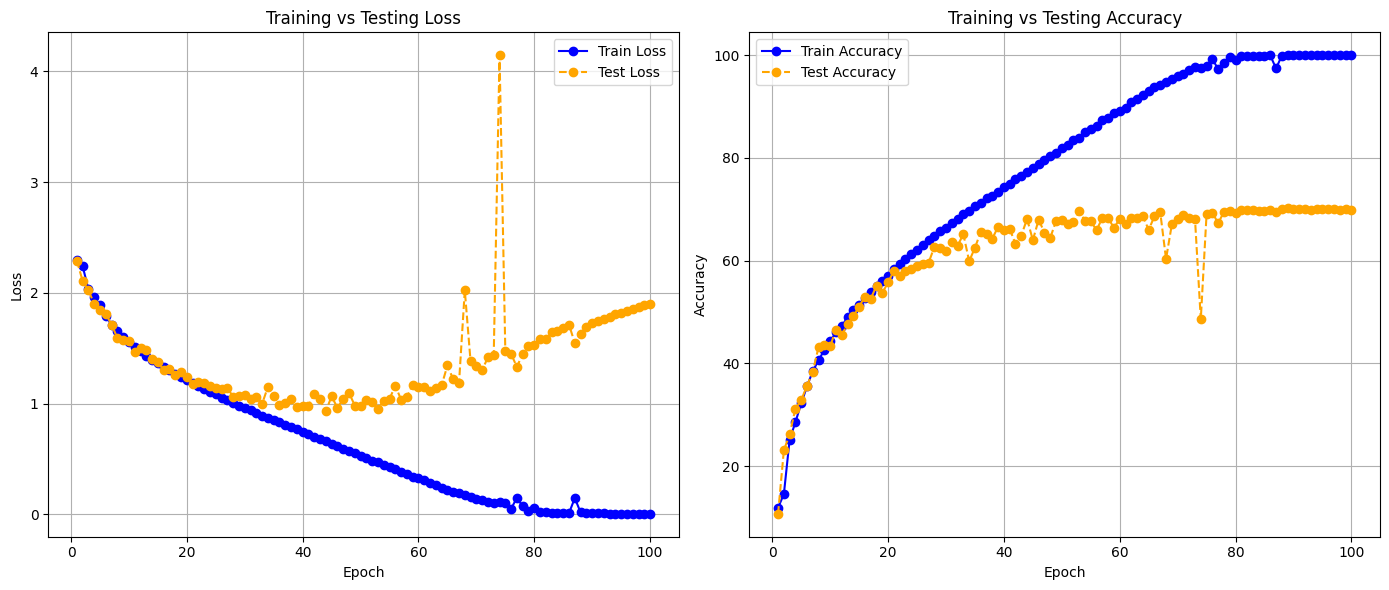

In [ ]:
main(batch_size=128, lr=0.01, epochs=100, cuda=True, plot_name="cifar10_learning.png")

### Study of the effect of learning rate and batch size:



Running experiment with batch size = 128, learning rate = 0.001
Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 ===
[TRAIN Batch 000/391]	Time 0.135s (0.135s)	Loss 2.2979 (2.2979)	Prec@1  11.7 ( 11.7)	Prec@5  59.4 ( 59.4)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfba4d66f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfba4d66f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

[TRAIN Batch 200/391]	Time 0.034s (0.041s)	Loss 2.3045 (2.3024)	Prec@1   8.6 ( 10.2)	Prec@5  43.0 ( 49.6)

===============> Total time 16s	Avg loss 2.3020	Avg Prec@1 10.00 %	Avg Prec@5 50.03 %

[EVAL Batch 000/079]	Time 0.283s (0.283s)	Loss 2.3041 (2.3041)	Prec@1   7.8 (  7.8)	Prec@5  46.1 ( 46.1)

===============> Total time 2s	Avg loss 2.3017	Avg Prec@1  9.96 %	Avg Prec@5 49.82 %

=== EPOCH 2 ===
[TRAIN Batch 000/391]	Time 0.238s (0.238s)	Loss 2.3029 (2.3029)	Prec@1   9.4 (  9.4)	Prec@5  47.7 ( 47.7)
[TRAIN Batch 200/391]	Time 0.034s (0.030s)	Loss 2.3002 (2.3015)	Prec@1  10.9 (  9.9)	Prec@5  48.4 ( 49.9)

===============> Total time 10s	Avg loss 2.3013	Avg Prec@1  9.98 %	Avg Prec@5 50.08 %

[EVAL Batch 000/079]	Time 0.121s (0.121s)	Loss 2.3031 (2.3031)	Prec@1   8.6 (  8.6)	Prec@5  48.4 ( 48.4)

===============> Total time 1s	Avg loss 2.3009	Avg Prec@1 10.15 %	Avg Prec@5 50.15 %

=== EPOCH 3 ===
[TRAIN Batch 000/391]	Time 0.122s (0.122s)	Loss 2.2993 (2.2993)	Prec@1  11.7 ( 11.7)	Prec@

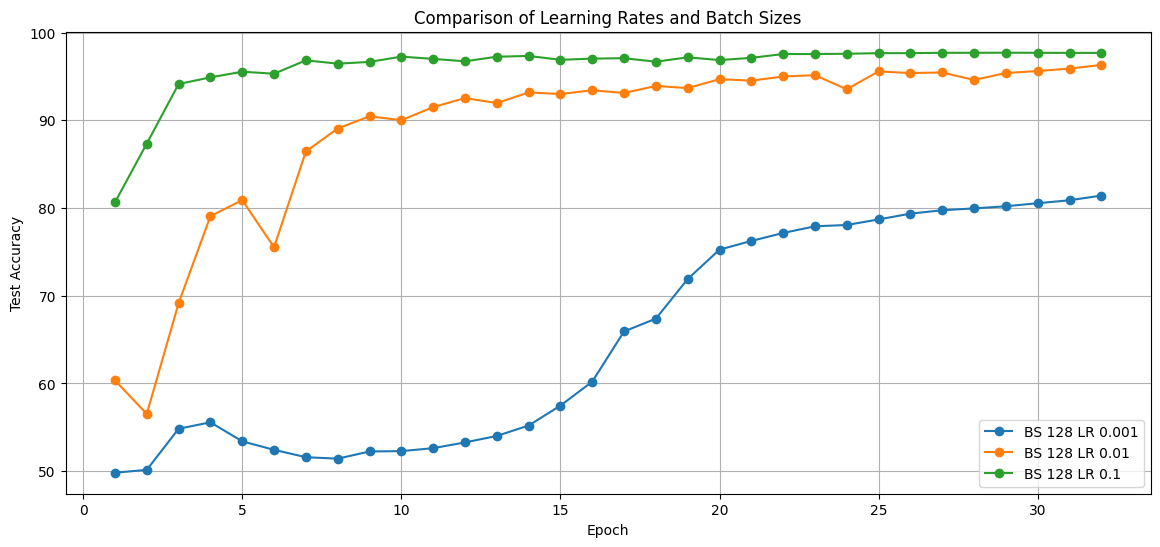

In [ ]:
import numpy as np


def run_experiment(batch_size, lr, epochs=32, cuda=True):
    print(f"\nRunning experiment with batch size = {batch_size}, learning rate = {lr}")

    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    if cuda:
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # Initialize enhanced plotter
    enhanced_plot = EnhancedAccLossPlot()

    for epoch_num in range(epochs):
        print(f"=== EPOCH {epoch_num+1} ===")
        # Train phase
        top1_acc, top1_acc, train_loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top1_acc_test, test_loss = epoch(test, model, criterion, cuda=cuda)

        # Update enhanced plotter
        enhanced_plot.update(train_loss.avg, test_loss.avg, top1_acc.avg, top1_acc_test.avg, epoch_num+1)

    return enhanced_plot

# Function to plot aggregated results from different experiments
def plot_aggregated_results(plots, title):
    plt.figure(figsize=(14, 6))

    for plot in plots:
        label = f"BS {plot['batch_size']} LR {plot['lr']}"
        plt.plot(plot['plotter'].epochs, plot['plotter'].test_accuracies, label=label, marker='o')

    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function to run multiple experiments
def main_experiments():
    learning_rates = [0.001, 0.01, 0.1]
    batch_size = 128
    epochs = 32  # You can change this value based on your experiment needs
    plots = []

    for lr in learning_rates:
      plotter = run_experiment(batch_size, lr, epochs)
      plots.append({'batch_size': batch_size, 'lr': lr, 'plotter': plotter})

    # Plot all experiments in the same graph
    plot_aggregated_results(plots, "Comparison of Learning Rates and Batch Sizes")

# Entry point for the script
if __name__ == "__main__":
    main_experiments()

## 3.Results improvements
### 3.1 Standardization of examples



In [ ]:
def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201)),
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201)),
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.334s (0.334s)	Loss 2.3020 (2.3020)	Prec@1   8.6 (  8.6)	Prec@5  54.7 ( 54.7)
[TRAIN Batch 200/391]	Time 0.014s (0.036s)	Loss 2.1813 (2.2636)	Prec@1  21.9 ( 17.6)	Prec@5  68.8 ( 62.1)

===============> Total time 14s	Avg loss 2.1529	Avg Prec@1 22.19 %	Avg Prec@5 69.17 %

[EVAL Batch 000/079]	Time 0.159s (0.159s)	Loss 1.8812 (1.8812)	Prec@1  39.8 ( 39.8)	Prec@5  83.6 ( 83.6)

===============> Total time 2s	Avg loss 1.9352	Avg Prec@1 30.09 %	Avg Prec@5 79.73 %

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.178s (0.178s)	Loss 1.9001 (1.9001)	Prec@1  30.5 ( 30.5)	Prec@5  83.6 ( 83.6)
[TRAIN Batch 200/391]	Time 0.037s (0.033s)	Loss 1.7377 (1.8794)	Prec@1  35.2 ( 32.5)	Prec@5  90.6 ( 82.7)

===============> Total time 13s	Avg loss 1.8101	Avg Prec@1 34.79 %	Avg Prec@5 84.69 %

[EVAL Batch 000/079]	Time 0.157s (0.157s)	Loss 1.6620 (1.6620)	Prec@1  41.4 ( 41.4)	Prec@5  84

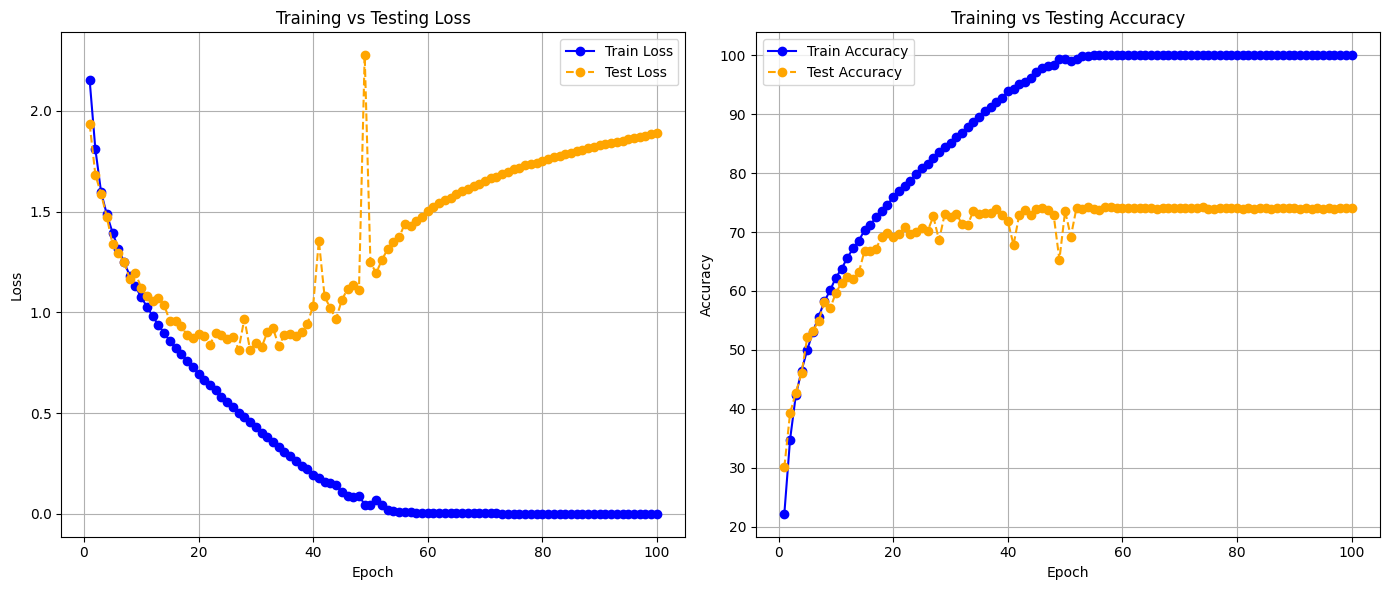

In [ ]:
main(128, 0.01,epochs=100, cuda=True, plot_name="result_standard.png")

#### Study of the effect of using multiple normalization schemes (zca, min-max etc) on the performance of our model.


Running experiment with batch size = 128, learning rate = 0.01, normalization = zca


100%|██████████| 170498071/170498071 [00:03<00:00, 44027845.60it/s]


Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified
=== EPOCH 1 ===
[TRAIN Batch 000/391]	Time 2.264s (2.264s)	Loss 2.3012 (2.3012)	Prec@1  13.3 ( 13.3)	Prec@5  52.3 ( 52.3)
[TRAIN Batch 200/391]	Time 0.014s (0.106s)	Loss 2.2753 (2.2914)	Prec@1  21.9 ( 14.3)	Prec@5  62.5 ( 58.4)

===============> Total time 38s	Avg loss 2.2580	Avg Prec@1 16.92 %	Avg Prec@5 62.59 %

[EVAL Batch 000/079]	Time 0.231s (0.231s)	Loss 2.1737 (2.1737)	Prec@1  22.7 ( 22.7)	Prec@5  72.7 ( 72.7)

===============> Total time 7s	Avg loss 2.1701	Avg Prec@1 19.06 %	Avg Prec@5 67.90 %

=== EPOCH 2 ===
[TRAIN Batch 000/391]	Time 0.246s (0.246s)	Loss 2.2126 (2.2126)	Prec@1  14.8 ( 14.8)	Prec@5  65.6 ( 65.6)
[TRAIN Batch 200/391]	Time 0.141s (0.099s)	Loss 2.1026 (2.1228)	Prec@1  25.0 ( 22.3)	Prec@5  68.8 ( 70.9)

===============> Total time 38s	Avg loss 2.0934	Avg Prec@1 23.79 %	Avg Prec@5 72.68 %

[EVAL Batch 000/079]	Time 0.435s (0.435s)	Loss 2.0333 (2.0333)	Prec@1  32.0 ( 32.0)

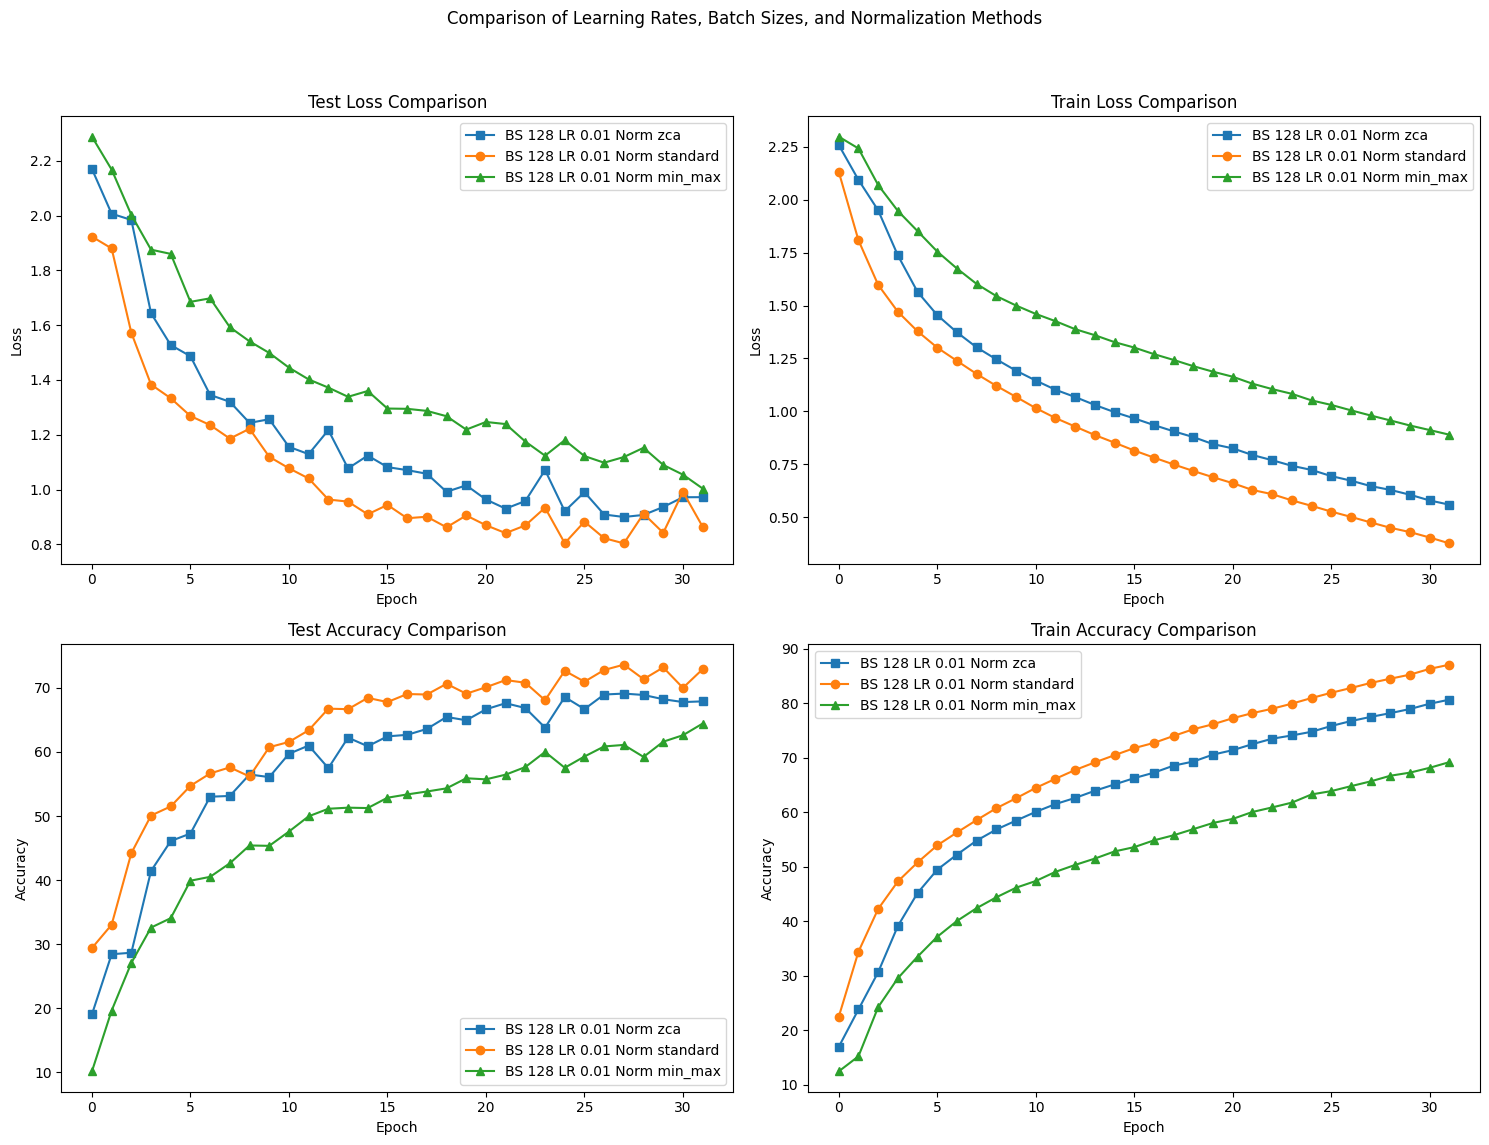

In [ ]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
from sklearn.decomposition import PCA
from torchvision.transforms import Lambda


# Function for ZCA Whitening
def zca_whitening(image):
    """
    Apply PCA whitening to an image. Assumes the input is a 3D numpy array (H x W x C).
    """
    flat_img = image.reshape(-1, 3)
    # Apply PCA
    pca = PCA(whiten=True)
    whitened = pca.fit_transform(flat_img)
    # Reshape to original dimensions
    whitened_img = whitened.reshape(image.shape)
    return torch.from_numpy(whitened_img).float()


def get_dataset(batch_size, cuda=False, normalization_type='standard'):
    download = True

    if normalization_type == 'standard':
        transform_train = transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201]),
        ])
    elif normalization_type == 'min_max':
        transform_train = transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x / x.max()),
        ])
    elif normalization_type == 'zca':
        # ZCA Whitening needs to be computed across the entire dataset, so this part is more complex
        # We'll apply this in the DataLoader later.
        transform_train = transform_test = transforms.Compose([
            transforms.ToTensor(),
            Lambda(lambda x: zca_whitening(x.numpy())),
        ])

    train_dataset = CIFAR10(
        PATH,
        train=True,
        download=download,
        transform=transform_train,
    )
    val_dataset = CIFAR10(
        PATH,
        train=False,
        download=download,
        transform=transform_test,
    )


    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=cuda,
        num_workers=2,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=cuda,
        num_workers=2,
    )

    return train_loader, val_loader

def run_experiment(batch_size, lr, epochs=32, cuda=True, normalization_type='standard'):
    print(f"\nRunning experiment with batch size = {batch_size}, learning rate = {lr}, normalization = {normalization_type}")

    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    if cuda:
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data with the specified normalization method
    train_loader, test_loader = get_dataset(batch_size, cuda, normalization_type=normalization_type)

    # Statistics to be returned
    stats = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': []
    }

    for epoch_num in range(epochs):
        print(f"=== EPOCH {epoch_num+1} ===")
        # Train phase
        train_acc, top5_acc, train_loss = epoch(train_loader, model, criterion, optimizer, cuda)
        # Test phase
        test_acc, top5_acc_test, test_loss = epoch(test_loader, model, criterion, cuda=cuda)

        # Update statistics
        stats['train_loss'].append(train_loss.avg)
        stats['train_accuracy'].append(train_acc.avg)
        stats['test_loss'].append(test_loss.avg)
        stats['test_accuracy'].append(test_acc.avg)

    return stats


import matplotlib.pyplot as plt

def plot_aggregated_results(plots, title):
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 plot grid

    # Set distinct markers for each normalization method for better visualization
    markers = {'standard': 'o', 'zca': 's', 'none': 'd', 'min_max': '^'}  # Add other normalization methods if needed

    # Accuracy and Loss plots for train and test sets
    for plot in plots:
        norm_method = plot['normalization']
        label = f"BS {plot['batch_size']} LR {plot['lr']} Norm {norm_method}"

        # Test Loss subplot
        axs[0, 0].plot(plot['stats']['test_loss'], label=label, marker=markers[norm_method])
        axs[0, 0].set_title('Test Loss Comparison')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].legend()

        # Train Loss subplot
        axs[0, 1].plot(plot['stats']['train_loss'], label=label, marker=markers[norm_method])
        axs[0, 1].set_title('Train Loss Comparison')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].set_ylabel('Loss')
        axs[0, 1].legend()

        # Test Accuracy subplot
        axs[1, 0].plot(plot['stats']['test_accuracy'], label=label, marker=markers[norm_method])
        axs[1, 0].set_title('Test Accuracy Comparison')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_ylabel('Accuracy')
        axs[1, 0].legend()

        # Train Accuracy subplot
        axs[1, 1].plot(plot['stats']['train_accuracy'], label=label, marker=markers[norm_method])
        axs[1, 1].set_title('Train Accuracy Comparison')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].set_ylabel('Accuracy')
        axs[1, 1].legend()

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect if the title overlaps with subplots
    plt.show()

def main_experiments(batch_size=128, lr=0.01, epochs=10, cuda=True):
    normalization_methods = ['zca', 'standard', 'min_max']  # Add other normalization methods if needed
    epochs = 32  # You can change this value based on your experiment needs
    plots = []
    for norm_method in normalization_methods:
      stats = run_experiment(batch_size, lr, epochs, cuda=cuda, normalization_type=norm_method)
      plots.append({
          'batch_size': batch_size,
          'lr': lr,
          'normalization': norm_method,
          'stats': stats
      })

    # Plot all experiments in the same graph
    plot_aggregated_results(plots, "Comparison of Learning Rates, Batch Sizes, and Normalization Methods")

# Call main_experiments to run the experiments
if __name__ == "__main__":
  main_experiments()

### Data Augmentation

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """
    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True) # The only modification
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.782s (0.782s)	Loss 2.3069 (2.3069)	Prec@1   7.0 (  7.0)	Prec@5  49.2 ( 49.2)
[TRAIN Batch 200/391]	Time 0.060s (0.052s)	Loss 2.2081 (2.2824)	Prec@1  26.6 ( 16.2)	Prec@5  65.6 ( 59.5)

===============> Total time 20s	Avg loss 2.1859	Avg Prec@1 20.52 %	Avg Prec@5 66.88 %

[EVAL Batch 000/079]	Time 0.132s (0.132s)	Loss 1.8854 (1.8854)	Prec@1  34.4 ( 34.4)	Prec@5  83.6 ( 83.6)

===============> Total time 2s	Avg loss 1.9413	Avg Prec@1 29.51 %	Avg Prec@5 80.57 %

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.223s (0.223s)	Loss 1.9483 (1.9483)	Prec@1  28.1 ( 28.1)	Prec@5  81.2 ( 81.2)
[TRAIN Batch 200/391]	Time 0.013s (0.050s)	Loss 1.9248 (1.9126)	Prec@1  29.7 ( 30.3)	Prec@5  82.8 ( 81.6)

===============> Total time 19s	Avg loss 1.8612	Avg Prec@1 32.20 %	Avg Prec@5 83.35 %

[EVAL Batch 000/079]	Time 0.145s (0.145s)	Loss 1.7915 (1.7915)	Prec@1  32.8 ( 32.8)	Prec@5  82.0 ( 82.0)

===============> Total time 2s	Avg loss 1.7659	Avg Prec@1 35.59 

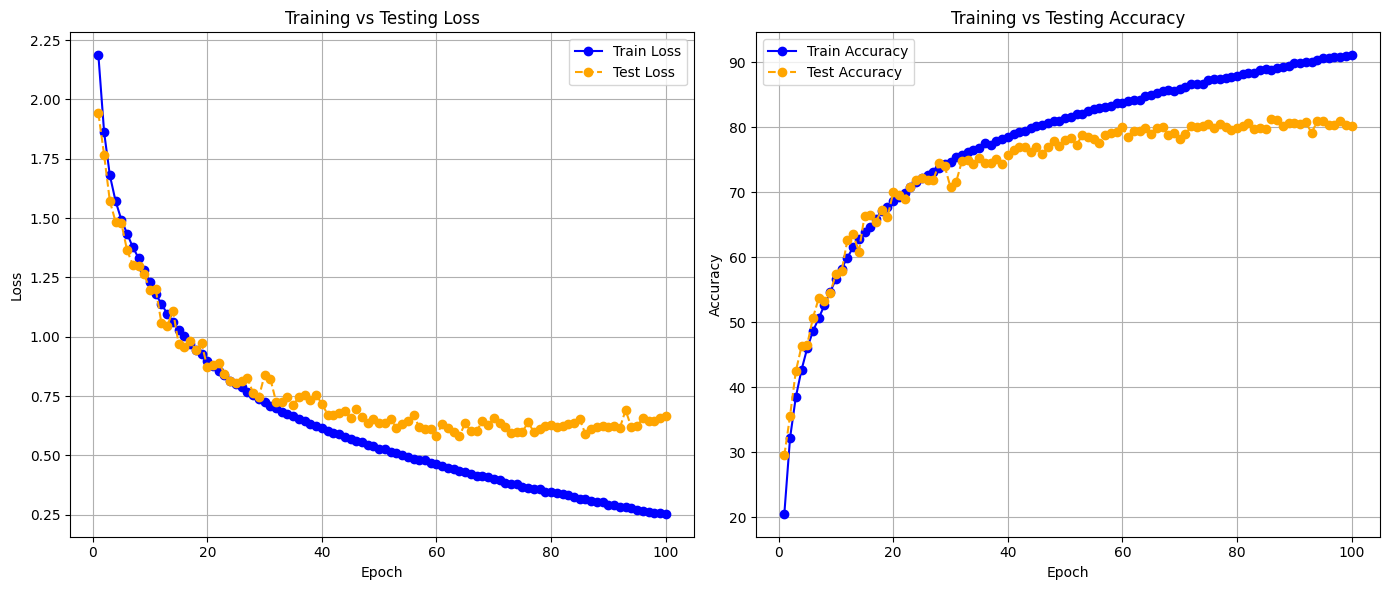

In [ ]:
main(batch_size=128, lr=0.01, epochs=100, cuda=True, transform = 'augmentation', plot_name="cifar10_augmentation.png")

#### Using another augmentation method (horizontal flipping)

This function will now apply random horizontal flips and adjust the color properties of the images in the training set, which can help the model generalize better by learning from more varied data. The test set remains unchanged from your current setup except for normalization, which should be the same as the training set to keep the data consistent between training and testing.

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_dataset(batch_size, cuda=False, transform=None):
    download = not os.path.exists(os.path.join(PATH, 'cifar-10-batches-py'))

    # Define the training transformation
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # CIFAR-10 normalization
    ])

    # Define the test transformation (usually less or no augmentation for testing)
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # CIFAR-10 normalization
    ])

    # Load datasets with transformations
    train_dataset = datasets.CIFAR10(
        PATH,
        train=True,
        download=download,
        transform=transform_train
    )
    val_dataset = datasets.CIFAR10(
        PATH,
        train=False,
        download=download,
        transform=transform_test,
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=cuda,
        num_workers=2,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=cuda,
        num_workers=2,
    )

    return train_loader, val_loader

100%|██████████| 170498071/170498071 [00:03<00:00, 54267501.14it/s]


Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 3.036s (3.036s)	Loss 2.3051 (2.3051)	Prec@1   7.0 (  7.0)	Prec@5  42.2 ( 42.2)
[TRAIN Batch 200/391]	Time 0.009s (0.112s)	Loss 2.2559 (2.2840)	Prec@1  19.5 ( 15.1)	Prec@5  62.5 ( 59.3)

===============> Total time 40s	Avg loss 2.2032	Avg Prec@1 19.64 %	Avg Prec@5 65.41 %

[EVAL Batch 000/079]	Time 0.120s (0.120s)	Loss 1.9213 (1.9213)	Prec@1  35.2 ( 35.2)	Prec@5  82.8 ( 82.8)

===============> Total time 2s	Avg loss 1.9675	Avg Prec@1 29.74 %	Avg Prec@5 78.53 %

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.429s (0.429s)	Loss 1.9299 (1.9299)	Prec@1  29.7 ( 29.7)	Prec@5  82.8 ( 82.8)
[TRAIN Batch 200/391]	Time 0.172s (0.103s)	Loss 1.8641 (1.9219)	Prec@1  38.3 ( 30.6)	Prec@5  83.6 ( 81.3)

===============> Total time 40s	Avg loss 1.8670	Avg Prec@1 32.52 %	Avg Prec@5 83.18 %

[EVAL Batch 000/079]	Time 0.121s (0.121s)	Loss 1.7579 (1.7579)	Prec@1  35.2 (

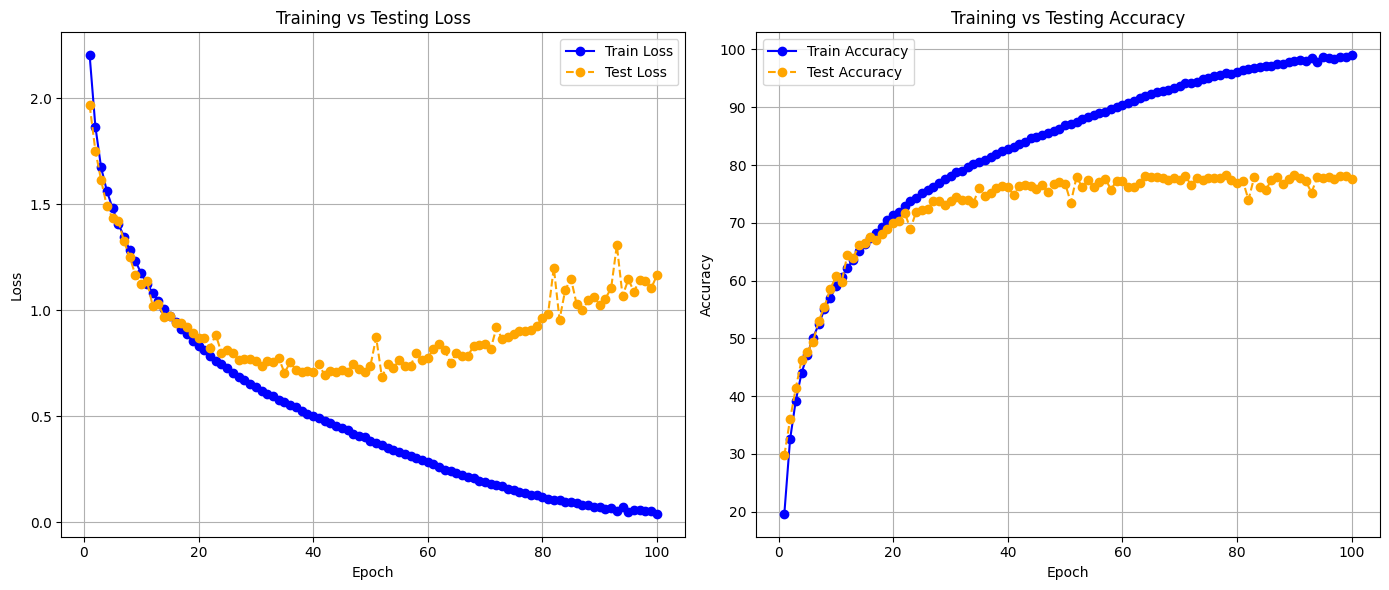

In [ ]:
main(batch_size=128, lr=0.01, epochs=100, cuda=True, transform = None, plot_name="cifar10_augmentationbyflip.png")

### Variants on the optimization algorithm
Until now, a simple optimization algorithm, the SGD, has been used. There are many variations of this
algorithm allowing faster or better convergence.
A common strategy consists in modifying the learning rate during the training (generally to decrease it), for
example, one can apply an exponential decrease to η according to the formula ηt = η × mt where t is the
epoch and m the momentum.


=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.215s (0.215s)	Loss 2.3045 (2.3045)	Prec@1   6.2 (  6.2)	Prec@5  42.2 ( 42.2)
[TRAIN Batch 200/391]	Time 0.031s (0.029s)	Loss 2.2990 (2.3012)	Prec@1  18.0 ( 12.5)	Prec@5  50.8 ( 50.1)

===============> Total time 9s	Avg loss 2.2992	Avg Prec@1 12.76 %	Avg Prec@5 50.48 %

[EVAL Batch 000/079]	Time 0.094s (0.094s)	Loss 2.2921 (2.2921)	Prec@1  12.5 ( 12.5)	Prec@5  49.2 ( 49.2)

===============> Total time 1s	Avg loss 2.2930	Avg Prec@1 12.17 %	Avg Prec@5 53.01 %

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.105s (0.105s)	Loss 2.2973 (2.2973)	Prec@1  13.3 ( 13.3)	Prec@5  47.7 ( 47.7)
[TRAIN Batch 200/391]	Time 0.017s (0.026s)	Loss 2.2666 (2.2849)	Prec@1  10.2 ( 11.4)	Prec@5  57.0 ( 53.6)

===============> Total time 9s	Avg loss 2.2597	Avg Prec@1 13.86 %	Avg Prec@5 59.54 %

[EVAL Batch 000/079]	Time 0.096s (0.096s)	Loss 2.1282 (2.1282)	Prec@1  25.8 ( 25.8)	Prec@5  76.6 ( 76.6)

===============> Total time 1s	Avg loss 2.1421	Avg Prec@1 21.44 %	

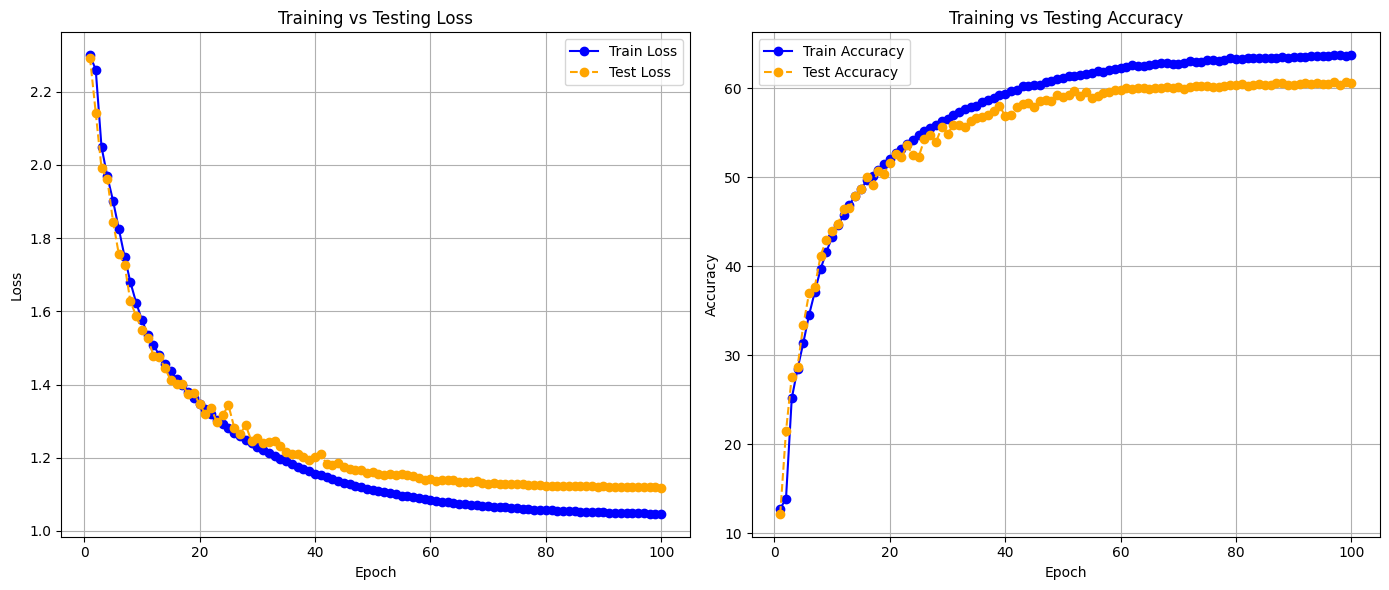

In [ ]:
main(batch_size=128, lr=0.01, epochs=100, cuda=True, transform = None, scheduler=True, plot_name="cifar10_gradientvariants.png")


Running experiment with batch size = 128, learning rate = 0.01, scheduling = ConstantLR
=== EPOCH 1 ===
[TRAIN Batch 000/391]	Time 1.038s (1.038s)	Loss 2.3035 (2.3035)	Prec@1  10.9 ( 10.9)	Prec@5  51.6 ( 51.6)
[TRAIN Batch 200/391]	Time 0.173s (0.049s)	Loss 2.2903 (2.2972)	Prec@1  21.1 ( 14.3)	Prec@5  63.3 ( 56.3)

===============> Total time 17s	Avg loss 2.2879	Avg Prec@1 17.53 %	Avg Prec@5 59.75 %

[EVAL Batch 000/079]	Time 0.125s (0.125s)	Loss 2.2486 (2.2486)	Prec@1  25.8 ( 25.8)	Prec@5  70.3 ( 70.3)

===============> Total time 2s	Avg loss 2.2588	Avg Prec@1 21.33 %	Avg Prec@5 66.28 %

=== EPOCH 2 ===
[TRAIN Batch 000/391]	Time 0.195s (0.195s)	Loss 2.2562 (2.2562)	Prec@1  18.8 ( 18.8)	Prec@5  68.8 ( 68.8)
[TRAIN Batch 200/391]	Time 0.013s (0.046s)	Loss 2.1428 (2.2231)	Prec@1  25.8 ( 22.0)	Prec@5  70.3 ( 67.3)

===============> Total time 18s	Avg loss 2.1664	Avg Prec@1 23.41 %	Avg Prec@5 70.68 %

[EVAL Batch 000/079]	Time 0.139s (0.139s)	Loss 2.0011 (2.0011)	Prec@1  36.7 ( 36.7)	Pre

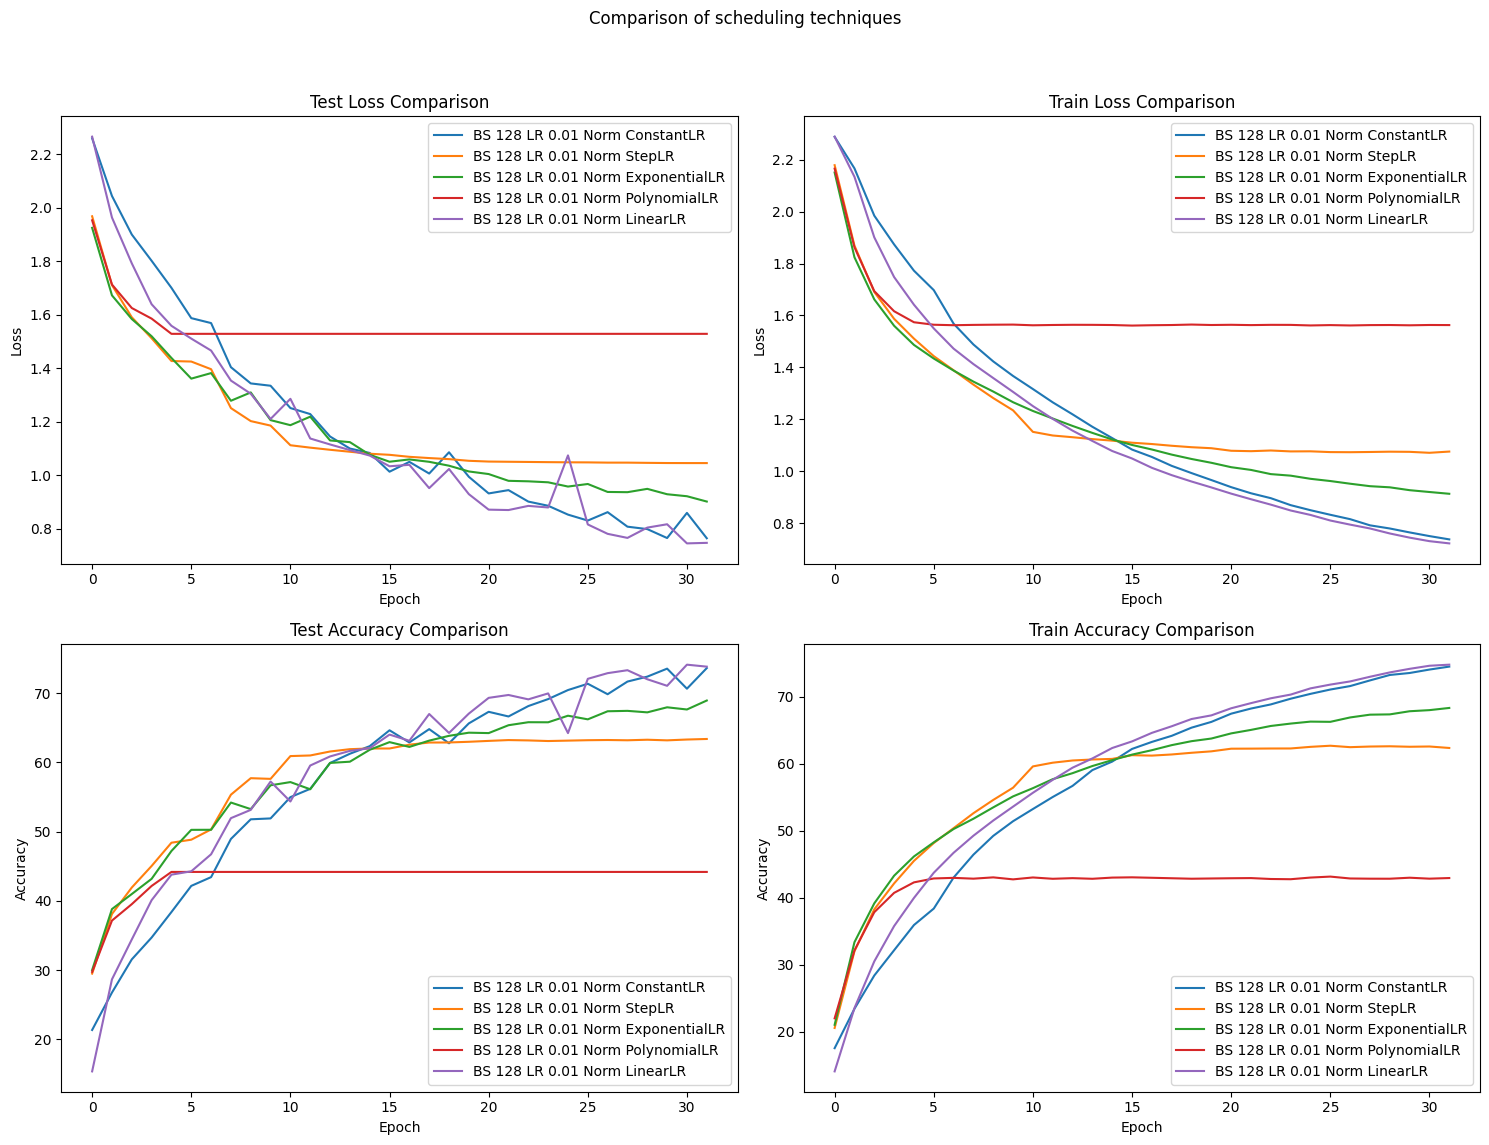

In [ ]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np


def run_experiment(batch_size, lr, epochs=32, cuda=True, scheduler="ExponentialLR", normalization_type='standard'):
    print(f"\nRunning experiment with batch size = {batch_size}, learning rate = {lr}, scheduling = {scheduler}")

    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    schedulers = {
        'ConstantLR': torch.optim.lr_scheduler.ConstantLR,
        'StepLR': torch.optim.lr_scheduler.StepLR,
        'ExponentialLR': torch.optim.lr_scheduler.ExponentialLR,
        'PolynomialLR': torch.optim.lr_scheduler.PolynomialLR,
        'LinearLR': torch.optim.lr_scheduler.LinearLR,
    }

    if scheduler=="ExponentialLR":
      lr_sched = schedulers['ExponentialLR'](optimizer, gamma=0.95)
    elif scheduler=="StepLR":
      lr_sched = schedulers['StepLR'](optimizer, step_size=10)
    else:
      lr_sched = schedulers[scheduler](optimizer)

    if cuda:
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data with the specified normalization method
    train_loader, test_loader = get_dataset(batch_size, cuda, transform='augmentation')

    # Statistics to be returned
    stats = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': []
    }

    for epoch_num in range(epochs):
        print(f"=== EPOCH {epoch_num+1} ===")
        # Train phase
        train_acc, top5_acc, train_loss = epoch(train_loader, model, criterion, optimizer, cuda)
        # Test phase
        test_acc, top5_acc_test, test_loss = epoch(test_loader, model, criterion, cuda=cuda)
        lr_sched.step()

        # Update statistics
        stats['train_loss'].append(train_loss.avg)
        stats['train_accuracy'].append(train_acc.avg)
        stats['test_loss'].append(test_loss.avg)
        stats['test_accuracy'].append(test_acc.avg)

    return stats

def plot_aggregated_results(plots, title):
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 plot grid

    # Accuracy and Loss plots for train and test sets
    for plot in plots:
        sch_method = plot['scheduling']
        label = f"BS {plot['batch_size']} LR {plot['lr']} Norm {sch_method}"

        # Test Loss subplot
        axs[0, 0].plot(plot['stats']['test_loss'], label=label)
        axs[0, 0].set_title('Test Loss Comparison')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].legend()

        # Train Loss subplot
        axs[0, 1].plot(plot['stats']['train_loss'], label=label)
        axs[0, 1].set_title('Train Loss Comparison')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].set_ylabel('Loss')
        axs[0, 1].legend()

        # Test Accuracy subplot
        axs[1, 0].plot(plot['stats']['test_accuracy'], label=label)
        axs[1, 0].set_title('Test Accuracy Comparison')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_ylabel('Accuracy')
        axs[1, 0].legend()

        # Train Accuracy subplot
        axs[1, 1].plot(plot['stats']['train_accuracy'], label=label)
        axs[1, 1].set_title('Train Accuracy Comparison')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].set_ylabel('Accuracy')
        axs[1, 1].legend()

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect if the title overlaps with subplots
    plt.show()

def main_experiments(batch_size=128, lr=0.01, epochs=10, cuda=True):
    scheduling_methods = ['ConstantLR', 'StepLR', 'ExponentialLR', 'PolynomialLR', 'LinearLR']  # Add other scheduling methods if needed
    epochs = 32  # You can change this value based on your experiment needs
    plots = []
    for sch_method in scheduling_methods:
      stats = run_experiment(batch_size, lr, epochs, cuda=cuda, scheduler=sch_method)
      plots.append({
          'batch_size': batch_size,
          'lr': lr,
          'scheduling': sch_method,
          'stats': stats
      })

    # Plot all experiments in the same graph
    plot_aggregated_results(plots, "Comparison of scheduling techniques")

# Call main_experiments to run the experiments
if __name__ == "__main__":
  main_experiments()

In [11]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """
    def __init__(self, p):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True) # The only modification
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

100%|██████████| 170498071/170498071 [00:03<00:00, 46663545.06it/s]


Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 1.357s (1.357s)	Loss 2.2990 (2.2990)	Prec@1  10.2 ( 10.2)	Prec@5  54.7 ( 54.7)
[TRAIN Batch 200/391]	Time 0.315s (0.366s)	Loss 2.2416 (2.2855)	Prec@1  21.1 ( 13.3)	Prec@5  71.9 ( 57.2)

===============> Total time 142s	Avg loss 2.1959	Avg Prec@1 18.19 %	Avg Prec@5 65.24 %

[EVAL Batch 000/079]	Time 0.429s (0.429s)	Loss 1.9437 (1.9437)	Prec@1  33.6 ( 33.6)	Prec@5  82.8 ( 82.8)

===============> Total time 13s	Avg loss 1.9452	Avg Prec@1 29.76 %	Avg Prec@5 80.57 %

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.645s (0.645s)	Loss 1.9030 (1.9030)	Prec@1  32.8 ( 32.8)	Prec@5  84.4 ( 84.4)
[TRAIN Batch 200/391]	Time 0.321s (0.374s)	Loss 1.9654 (1.9132)	Prec@1  27.3 ( 29.5)	Prec@5  78.1 ( 82.3)

===============> Total time 143s	Avg loss 1.8631	Avg Prec@1 31.28 %	Avg Prec@5 83.70 %

[EVAL Batch 000/079]	Time 0.419s (0.419s)	Loss 1.8956 (1.8956)	Prec@1  29.

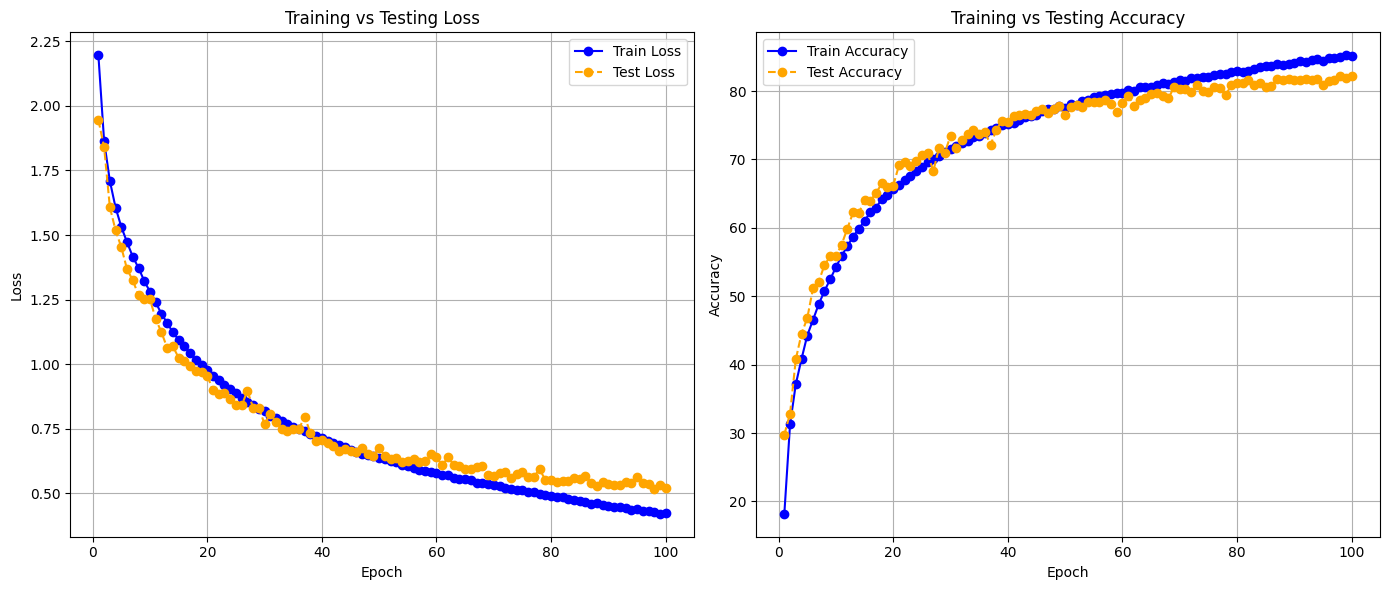

In [ ]:
main(batch_size=128, lr=0.01, epochs=100, cuda=False, transform = 'augmentation', plot_name="cifar10_dropout.png")

In [ ]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np


def run_experiment(batch_size, lr, epochs=32, cuda=True, p=0.5, scheduler=True, normalization_type='standard'):
    print(f"\nRunning experiment with batch size = {batch_size}, learning rate = {lr}, scheduling = {scheduler}")

    model = ConvNet(p)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    if scheduler:
      lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda:
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data with the specified normalization method
    train_loader, test_loader = get_dataset(batch_size, cuda, transform='augmentation')

    # Statistics to be returned
    stats = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': []
    }

    for epoch_num in range(epochs):
        print(f"=== EPOCH {epoch_num+1} ===")
        # Train phase
        train_acc, top5_acc, train_loss = epoch(train_loader, model, criterion, optimizer, cuda)
        # Test phase
        test_acc, top5_acc_test, test_loss = epoch(test_loader, model, criterion, cuda=cuda)
        if scheduler:
          lr_sched.step()

        # Update statistics
        stats['train_loss'].append(train_loss.avg)
        stats['train_accuracy'].append(train_acc.avg)
        stats['test_loss'].append(test_loss.avg)
        stats['test_accuracy'].append(test_acc.avg)

    return stats

def plot_aggregated_results(plots, title):
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 plot grid

    # Accuracy and Loss plots for train and test sets
    for plot in plots:
        p_value = plot['p']
        label = f"BS {plot['batch_size']} LR {plot['lr']} p {p_value}"

        # Test Loss subplot
        axs[0, 0].plot(plot['stats']['test_loss'], label=label)
        axs[0, 0].set_title('Test Loss Comparison')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].legend()

        # Train Loss subplot
        axs[0, 1].plot(plot['stats']['train_loss'], label=label)
        axs[0, 1].set_title('Train Loss Comparison')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].set_ylabel('Loss')
        axs[0, 1].legend()

        # Test Accuracy subplot
        axs[1, 0].plot(plot['stats']['test_accuracy'], label=label)
        axs[1, 0].set_title('Test Accuracy Comparison')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_ylabel('Accuracy')
        axs[1, 0].legend()

        # Train Accuracy subplot
        axs[1, 1].plot(plot['stats']['train_accuracy'], label=label)
        axs[1, 1].set_title('Train Accuracy Comparison')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].set_ylabel('Accuracy')
        axs[1, 1].legend()

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect if the title overlaps with subplots
    plt.show()

def main_experiments(batch_size=128, lr=0.01, epochs=10, cuda=False):
    p_values = [0.25, 0.5, 0.75]
    epochs = 32  # You can change this value based on your experiment needs
    plots = []
    for p in p_values:
      stats = run_experiment(batch_size, lr, epochs, cuda=cuda,p=p)
      plots.append({
          'batch_size': batch_size,
          'lr': lr,
          'p': p,
          'stats': stats
      })

    # Plot all experiments in the same graph
    plot_aggregated_results(plots, "Comparison of different values of p for dropout technique")

# Call main_experiments to run the experiments
if __name__ == "__main__":
  main_experiments()

In [9]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """
    def __init__(self, p=0.5):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 7.361s (7.361s)	Loss 2.3696 (2.3696)	Prec@1  10.2 ( 10.2)	Prec@5  43.0 ( 43.0)
[TRAIN Batch 200/391]	Time 0.017s (0.079s)	Loss 1.5737 (1.8799)	Prec@1  37.5 ( 31.2)	Prec@5  89.1 ( 82.3)

===============> Total time 25s	Avg loss 1.7216	Avg Prec@1 36.95 %	Avg Prec@5 86.45 %

[EVAL Batch 000/079]	Time 0.164s (0.164s)	Loss 1.4118 (1.4118)	Prec@1  53.9 ( 53.9)	Prec@5  92.2 ( 92.2)

===============> Total time 2s	Avg loss 1.4121	Avg Prec@1 50.00 %	Avg Prec@5 93.36 %

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.306s (0.306s)	Loss 1.4094 (1.4094)	Prec@1  41.4 ( 41.4)	Prec@5  94.5 ( 94.5)
[TRAIN Batch 200/391]	Time 0.074s (0.045s)	Loss 1.3428 (1.4189)	Prec@1  55.5 ( 48.6)	Prec@5  93.0 ( 92.7)

===============> Total time 18s	Avg loss 1.3659	Avg Prec@1 50.77 %	Avg Prec@5 93.47 %

[EVAL Batch 000/079]	Time 0.162s (0.162s)	Loss 1.1794 (1.1794)	Prec@1  64.8 ( 64.8)	Prec@5  91.4 ( 91.4)

===============> Total time 2s	Avg loss 1.2371	Avg Prec@1 55.26 

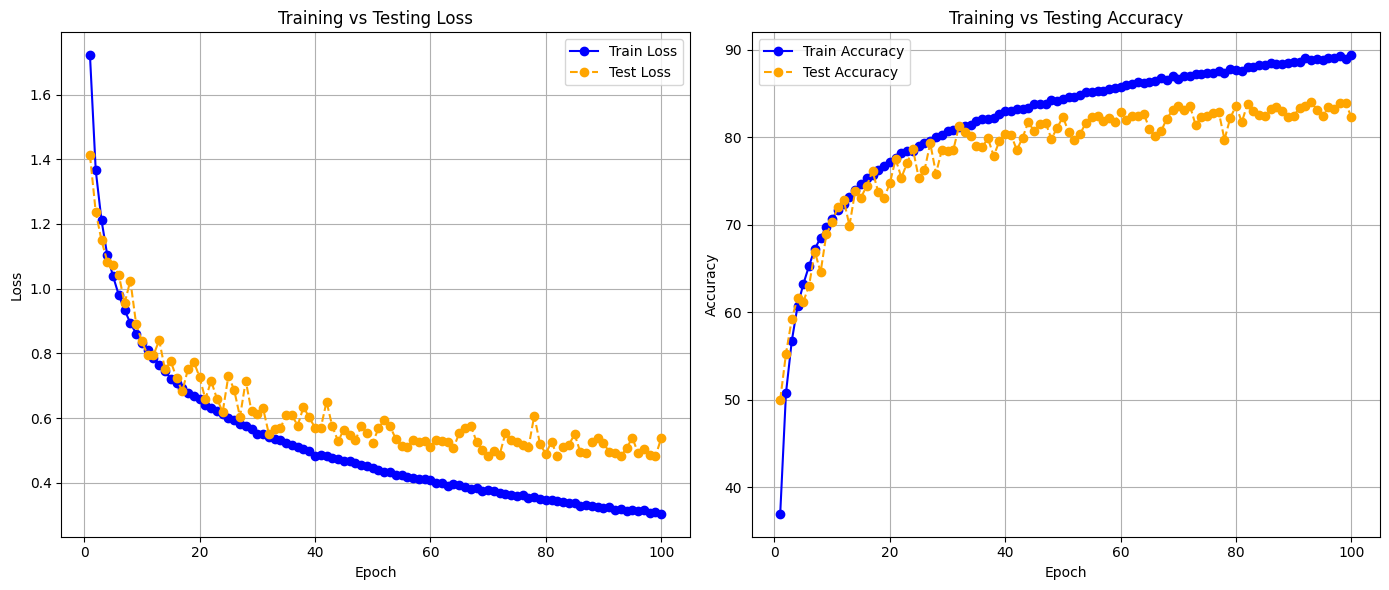

In [10]:
main(batch_size=128, lr=0.01, epochs=100, cuda=True, transform = 'augmentation', plot_name="cifar10_batchnormalization.png")